## Replication of Allen Institute preprocessing-sorting-postprocessing pipeline with SpikeInterface

This notebook aims to replicate the functionality of https://github.com/AllenInstitute/ecephys_spike_sorting repository.

### Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import spikeinterface.full as si
from probeinterface import read_probeinterface
from probeinterface.plotting import plot_probe
from adc_shifts import adc_shifts

%matplotlib widget

Matplotlib created a temporary cache directory at /tmp/matplotlib-crgrf1m5 because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Set pipeline parameters

In [ ]:
pipeline_info_dict = {}

In [2]:
# Data loading
num_channels = 384
sampling_frequency = 29999.954846
# see this thread https://community.brain-map.org/t/using-the-raw-data/1898 for gain scaling factor and dtype
gain_recording = 0.195
offset_recording = 0
dtype = np.int16

pipeline_info_dict.update({'num_channels': num_channels, 'sampling_frequency': sampling_frequency, 'gain_recording': gain_recording, 'offset_recording': offset_recording, 'dtype': dtype})

In [3]:
# Preprocessing and sorting
highpass_frequency = 150 # Hz

sorter_name = 'kilosort2'
sorter_path = Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images' / f'{sorter_name}-compiled-base.sif'
output_folder = Path.home()/'RANCZLAB-NAS/iakov/allen_sorting_ks2_16_jan_v_corr'
remove_existing_folder = True

pipeline_info_dict.update({'sorter_name': sorter_name, 'sorter_path': sorter_path, 'output_folder': output_folder, 'remove_existing_folder': remove_existing_folder})

In [4]:
# Other
backend = 'ipywidgets'

pipeline_info_dict.update({'backend': backen})

### Loading the data

#### Reading the binary file

In [5]:
# Main working directory
base_folder = Path.home() / 'RANCZLAB-NAS' / 'iakov' / 'data' / 'sid_715093703_pid_810755797'

# Input data
binary_filename = 'spike_band.dat'

# # Output sorting
# output_folder = base_folder / 'kilosort3_sorting_files'
# sorting_save_path = base_folder / 'kilosort3_sorting_output'

pipeline_info_dict.update({'data_path': base_folder, 'binary_filename': binary_filename})

https://eu-north-1.console.aws.amazon.com/s3/object/allen-brain-observatory?region=us-west-2&prefix=visual-coding-neuropixels/raw-data/715093703/810755797/spike_band.dat

Amazon S3 /
Buckets /
allen-brain-observatory /
visual-coding-neuropixels /
raw-data /
715093703 /
810755797 /
spike_band.dat


In [6]:
recordings = {}
recordings['raw'] = si.read_binary(base_folder / binary_filename, sampling_frequency=sampling_frequency, dtype=dtype, num_channels=num_channels, gain_to_uV=1.0, offset_to_uV=0)
recordings['raw'] = si.scale(recordings['raw'], gain=gain_recording, offset=offset_recording) #scale to uV
recordings['raw']

ScaleRecording: 384 channels - 30.0kHz - 1 segments - 257,175,972 samples - 8,572.55s (2.38 hours) 
                float32 dtype - 367.89 GiB

#### Attaching the probe configuration

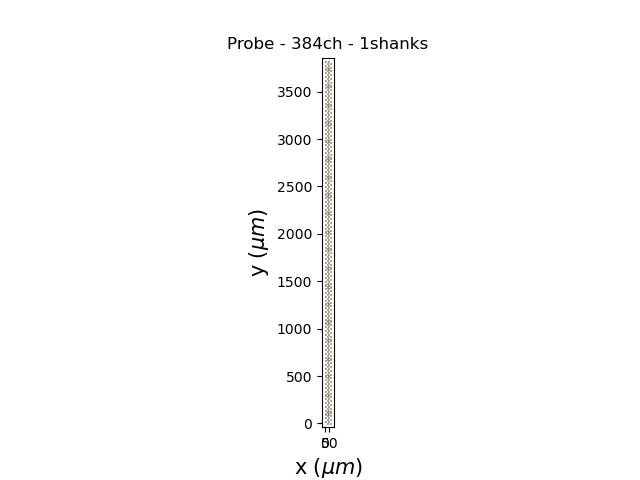

In [7]:
probegroup = read_probeinterface('../../pipeline/np_json_files/np1.json')
probe = probegroup.probes[0]
recordings['raw'] = recordings['raw'].set_probe(probe)

plot_probe(probe)
plt.show()

### Preprocessing

In [8]:
# perform the phase shift (similar to IBL destriping or `tshift` option in CatGT):
recordings['preprocessed'] = si.phase_shift(recordings['raw'], inter_sample_shift=adc_shifts()[0])

In [9]:
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = si.detect_bad_channels(recordings['preprocessed'])
recordings['preprocessed'] = recordings['preprocessed'].remove_channels(remove_channel_ids=bad_channel_ids)

pipeline_info_dict.update({'channel_labels': channel_labels, 'bad_channel_ids': bad_channel_ids})

In [10]:
print('Channels removed:', {k: channel_labels[k] for k in bad_channel_ids})

Channels removed: {0: 'out', 1: 'out', 2: 'out', 3: 'out', 4: 'out', 5: 'out', 6: 'out', 7: 'out', 8: 'out', 9: 'out', 10: 'out', 11: 'out', 12: 'out', 13: 'out', 14: 'out', 15: 'out', 16: 'out', 17: 'out', 18: 'out', 19: 'out', 20: 'out', 21: 'out', 22: 'out', 23: 'out', 24: 'out', 25: 'out', 26: 'out', 27: 'out', 28: 'out', 29: 'out', 30: 'out', 31: 'out', 32: 'out', 33: 'out', 34: 'out', 35: 'out', 36: 'out', 37: 'out', 38: 'out', 39: 'out', 40: 'out', 41: 'out', 42: 'out', 43: 'out', 44: 'out', 45: 'out', 46: 'out', 47: 'out', 48: 'out', 49: 'out', 50: 'out', 51: 'out', 52: 'out', 53: 'out', 54: 'out', 55: 'out', 56: 'out', 57: 'out', 58: 'out', 59: 'out', 60: 'out', 61: 'out', 62: 'out', 63: 'out', 64: 'out', 65: 'out', 66: 'out', 67: 'out', 68: 'out', 69: 'out', 70: 'out', 71: 'out', 72: 'out', 73: 'out', 74: 'out', 75: 'out', 76: 'out', 77: 'out', 78: 'out', 79: 'dead', 112: 'noise', 144: 'noise', 151: 'noise', 188: 'noise', 193: 'dead', 227: 'noise', 264: 'noise', 303: 'noise',

In [11]:
recordings['preprocessed'] = si.highpass_filter(recordings['preprocessed'], freq_min=highpass_frequency)

In [12]:
# subtract the median across all channels
recordings['preprocessed'] = si.common_reference(recordings['preprocessed'], operator="median", reference="global")

In [13]:
parameter_dict = si.get_default_sorter_params(sorter_name)

In [14]:
parameter_dict['projection_threshold'] = [10, 4]
parameter_dict['freq_min'] = 150
parameter_dict['minfr_goodchannels'] = 0.1
parameter_dict['freq_min'] = highpass_frequency
# parameter_dict['lam'] = 10 # default value already
parameter_dict['AUCsplit'] = 0.9
parameter_dict['minFR'] = 1/50
# parameter_dict['momentum'] = [20, 400] # default value already
parameter_dict['sigmaMask'] = 30
parameter_dict['preclust_threshold'] = 8
parameter_dict['skip_kilosort_preprocessing'] = False

# parameter_dict['scaleproc'] = 200

parameter_dict['n_jobs'] = -1

pipeline_info_dict.update({'parameter_dict': parameter_dict})

In [15]:
print(parameter_dict)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.02, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': -1, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


### Plot raster

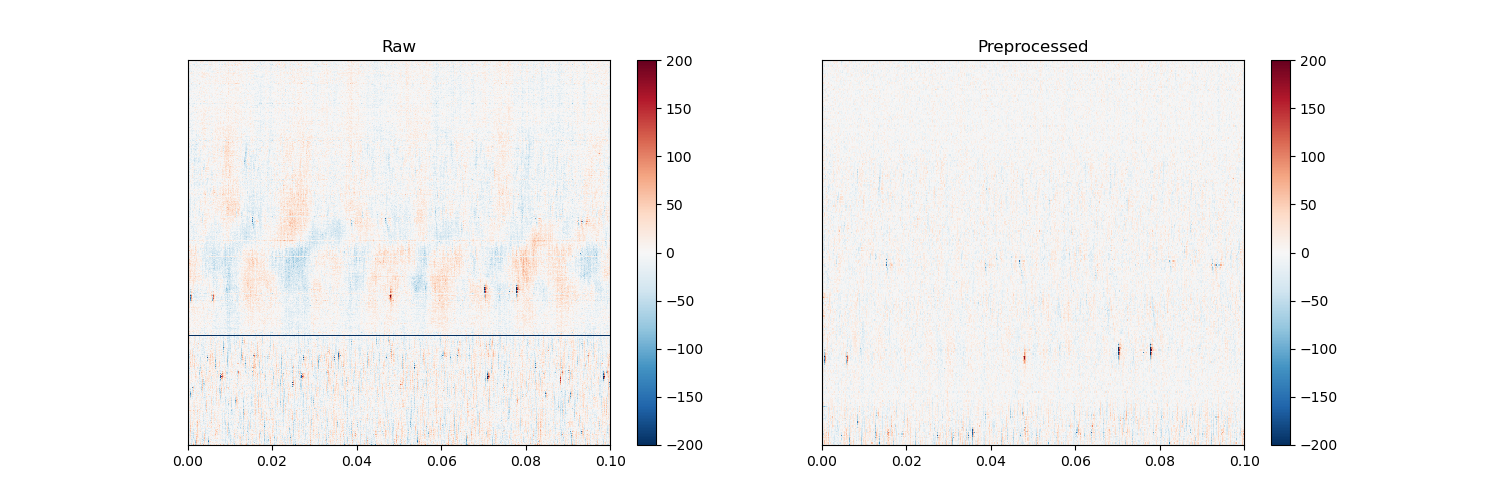

In [16]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].set_title('Raw')
si.plot_traces(recordings['raw'], mode='map', time_range=[0, 0.1], backend='matplotlib', ax=ax[0])
ax[1].set_title('Preprocessed')
si.plot_traces(recordings['preprocessed'], mode='map', time_range=[0, 0.1], backend='matplotlib', ax=ax[1])
plt.show()

In [17]:
si.plot_traces(recordings['preprocessed'], mode='map', time_range=[0, 0.1], backend=backend, height_cm=25, width_cm=60)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Save pipeline information into json file

In [ ]:
with open(output_folder/'pipeline_info.json', 'w') as fp:
    json.dump(pipeline_info_dict, fp)

### Run sorting

In [ ]:
sorting = si.run_sorter(sorter_name, recording=recordings['preprocessed'], output_folder=output_folder, singularity_image=sorter_path, verbose=True, remove_existing_folder=remove_existing_folder, **parameter_dict)
sorting.save(folder=output_folder/'si_save', format='npz_folder', **parameter_dict)

Starting container
Installing spikeinterface from sources in /home/jupyter-ikharitonov/RANCZLAB-NAS/spikesorter_images/kilosort2-compiled-base.sif
Installing dev spikeinterface from remote repository
Running kilosort2 sorter inside /home/jupyter-ikharitonov/RANCZLAB-NAS/spikesorter_images/kilosort2-compiled-base.sif


### Postprocessing

In [ ]:
# returns a new sorting object with putative double-counted spikes removed
cleaned_sorting = si.remove_duplicated_spikes(sorting=sorting, 
                                           censored_period=0.3, # in ms
                                           method='keep_first')

In [ ]:
# the waveforms are sparse so it is faster to export to phy
we = si.extract_waveforms(recording=recordings['preprocessed'], sorting=cleaned_sorting, folder='waveforms')

# compute some metrics needed for this module:
spike_amplitudes = si.compute_spike_amplitudes(waveform_extractor=we)
principal_components = si.compute_principal_components(waveform_extractor=we, 
                                 n_components=5, 
                                 mode='by_channel_global')

# save the data in a specified location
si.export_to_phy(waveform_extractor=we, 
              output_folder=output_folder/'phy_folder')

In [ ]:
template_metrics = si.compute_template_metrics(we)
# display(template_metrics)

In [ ]:
# # or load waveforms that have already been extracted:
# we = si.load_waveforms(folder='waveforms')

# # calculate metrics that don't require principal components:
# metrics = compute_quality_metrics(waveform_extractor=we)

# # or compute principal components before passing on the waveform extractor:
# pca = compute_principal_components(waveform_extractor=we, 
#                                    n_components=5, 
#                                    mode='by_channel_local')
metrics = si.compute_quality_metrics(waveform_extractor=we)

In [ ]:
template_similarity = si.compute_template_similarity(we)
correlograms = si.compute_correlograms(we)

# Returns a list of unit pairs that should be merged
potential_merges = si.get_potential_auto_merge(we)